In [1]:
########## Calling relevant libraries ##########
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

import scipy, sqlite3, h5py

import pandas as pd

import sklearn
import sklearn.model_selection as model_selection
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor

import rampy as rp

import sys
sys.path.append("/home/charles/GoogleDrive/viscopy/")
sys.path.append("/home/charles/GoogleDrive/structupy/")
import viscopy as vp
import structupy as spy

In [174]:
sio2 = np.random.rand(6000)*0.5+0.5

Xk = np.random.rand(6000)
AlM = np.random.rand(6000)

remain = 1-sio2

al2o3 = AlM * remain
alkalis = 1.0 - sio2 - al2o3

na2o = (1-Xk)*alkalis
k2o = Xk*alkalis

X = pd.DataFrame()
X["sio2"] = sio2
X["al2o3"] = al2o3
X["k2o"] = k2o
X["na2o"] = na2o

X_ = vp.chimie_control(X)
ap, b = vp.heatcp(X_,Cp_glass = "3R")
n_b_o = spy.nbot(X_)
atoms_ = spy.atoms(X_)

In [267]:
def fentropy(x,at):
    e_si = 5.1
    e_al = 2.2
    e_na = 15.0
    e_k = 20.0
    
    linear = e_si * x.loc[:,"sio2"] + e_al*x.loc[:,"al2o3"] + e_na*x.loc[:,"na2o"] + e_k*x.loc[:,"k2o"]
    
    n = 3*x.loc[:,"sio2"] + 5*x.loc[:,"al2o3"] + 3*x.loc[:,"na2o"] + 3*x.loc[:,"k2o"]
    
    Xk = at.loc[:,"k"]/(at.loc[:,"na"] + at.loc[:,"k"])
    AlM = at.loc[:,"al"]/(at.loc[:,"na"] + at.loc[:,"k"]+at.loc[:,"al"])
    AlSi = at.loc[:,"al"]/(at.loc[:,"si"]+at.loc[:,"al"])
    
    
    mixing1 = -(at.k+at.na)/at.o*2*8.314*(Xk*np.log(Xk))
    mixing2 = -(at.al+at.k+at.na)/at.o*2*8.314*(at.k*np.log(at.k)+at.na*np.log(at.na)+at.al*np.log(at.al))
    mixing3 = -(at.si+at.al)/at.o*2*8.314*(AlSi*np.log(AlSi))
    
    return linear + mixing1 + mixing2 + mixing3


def fBe(x,at):
    Be_si = 100000
    Be_al = 30000
    Be_na = 15000
    Be_k = 12000
    
    linear = Be_si * x.loc[:,"sio2"] + Be_al*x.loc[:,"al2o3"] + Be_na*x.loc[:,"na2o"] + Be_k*x.loc[:,"k2o"]
    
    entropy_inf = 500 * fentropy(x,at)
    
    return linear + entropy_inf


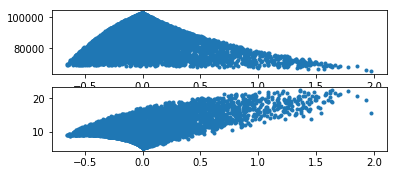

In [268]:
plt.subplot(3,1,1)
plt.plot(n_b_o.loc[:,"nbot"],fBe(X_,atoms_).values,".")
plt.subplot(3,1,2)
plt.plot(n_b_o.loc[:,"nbot"],fentropy(X_,atoms_).values,".")


In [272]:
X_["ap"] = ap
X_["b"] = b
X_["entropy"] = fentropy(X_,atoms_)
X_["Be"] = fBe(X_,atoms_)
X_.to_csv("./fake_X.csv",index=False)

In [256]:
train_X, test_X = model_selection.train_test_split(X_,test_size=0.995)
y_train = np.vstack((fentropy(train_X,spy.atoms(train_X)).values,fBe(train_X,spy.atoms(train_X)).values)).T 
y_test = np.vstack((fentropy(test_X,spy.atoms(test_X)).values,fBe(test_X,spy.atoms(test_X)).values)).T 

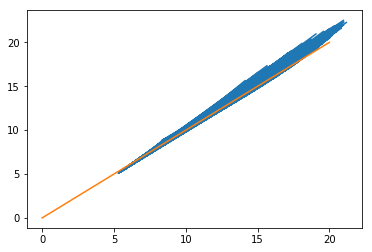

In [258]:
model1 =rp.mlregressor(train_X,fentropy(train_X,spy.atoms(train_X)).values)
model1.scaler = 'StandardScaler'
model1.param_neurons['hidden_layer_sizes'] = (5) 
model1.param_neurons['activation'] = "tanh"
model1.algorithm = "NeuralNet"
model1.param_neurons['solver'] = "lbfgs"
model1.param_neurons['max_iter'] = 1000
model1.fit()
model1.fit()
y_pred_test = model1.predict(X_)
plt.plot(y_pred_test,fentropy(X_,spy.atoms(X_)).values)
plt.plot([0,20],[0,20])

In [248]:
train_X.shape

(30, 16)

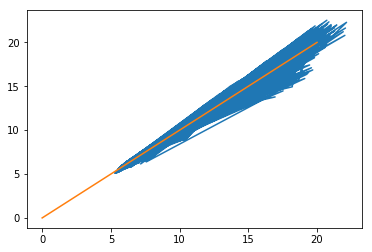